## Gathered Notebook

This notebook was generated by the Gather Extension. The intent is that it contains only the code and cells required to produce the same results as the cell originally selected for gathering. Please note that the Python analysis is quite conservative, so if it is unsure whether a line of code is necessary for execution, it will err on the side of including it.

**Please let us know if you are satisfied with what was gathered [here](https://aka.ms/gatherfeedback).**

Thanks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import torch
from dptb.nnops.nnapi import DeePTB
import matplotlib.pyplot as plt
import json
from dptb.utils.tools import j_loader, Index_Mapings
from dptb.nnsktb.sknet import SKNet

from dptb.nnsktb.integralFunc import SKintHops
from dptb.nnsktb.onsiteFunc import onsiteFunc, loadOnsite
from dptb.dataprocess.processor import Processor
from dptb.nnsktb.skintTypes import all_skint_types
from dptb.hamiltonian.hamil_eig_sk import HamilEig
from dptb.nnops.nnapi import NNSK
import torch as th
from dptb.nnsktb.sknet import SKNet

# N-N: 7  independent hoppings
## 2s-2s: [0]    2s-2p: [1]    2s-s*: [2]    2p-2s: [1]    2p-2p: [3, 4]    2p-s*: [5]    
## s*-2s: [2]    s*-2p: [5]    s*-s*: [6]    
# N-B: 10  independent hoppings
## 2s-2s: [0]    2s-2p: [1]    2s-s*: [2]    2p-2s: [3]    2p-2p: [4, 5]    2p-s*: [6]    
## s*-2s: [7]    s*-2p: [8]    s*-s*: [9]    
# B-N: 10  independent hoppings
## 2s-2s: [0]    2s-2p: [3]    2s-s*: [7]    2p-2s: [1]    2p-2p: [4, 5]    2p-s*: [8]    
## s*-2s: [2]    s*-2p: [6]    s*-s*: [9]    
# B-B: 7  independent hoppings
## 2s-2s: [0]    2s-2p: [1]    2s-s*: [2]    2p-2s: [1]    2p-2p: [3, 4]    2p-s*: [5]    
## s*-2s: [2]    s*-2p: [5]    s*-s*: [6]    
# N: {'2s': [0], '2p': [1], 's*': [2]}  independent onsite Es
## 2s: [0]    2p: [1]    s*: [2]    
# B: {'2s': [0], '2p': [1], 's*': [2]}  independent onsite Es
## 2s: [0]    2p: [1]    s*: [2]    
# initial rotate H or S func.
# N-N: 7  independent hoppings
## 2s-2s: [0]    2s-2p: [1]    2s-s*: [2]    2p-2s: [1]    2p-2p: [

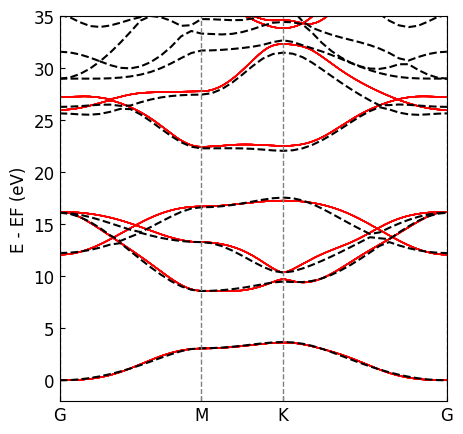

In [2]:
checkpoint='/root/dptb_exp/checkpoint_1/best_nnsk.pth'
input = '/root/dptb_exp/checkpoint_1/input.json'
jdata = j_loader(input)
cutoff = jdata['data_options']['bond_cutoff']
proj_atom_anglr_m = jdata['data_options']['proj_atom_anglr_m']
proj_atom_neles = jdata['data_options']['proj_atom_neles']
f=torch.load(checkpoint)
model_config = f["model_config"]
onsitemode =  model_config['onsitemode']
nnsk = NNSK(checkpoint, proj_atom_anglr_m)
strase = read('/root/deeptb/examples/TBmodel/hBN/check/hBN.vasp')
struct = BaseStruct(atom=strase, format='ase', cutoff=cutoff, proj_atom_anglr_m=proj_atom_anglr_m, proj_atom_neles=proj_atom_neles, onsitemode=onsitemode, time_symm=True)
snapase = struct.struct
lat = snapase.cell.get_bravais_lattice()
special_kp = lat.get_special_points()
kpath=snapase.cell.bandpath('GMKG', npoints=220)
xlist, high_sym_kpoints, labels = kpath.get_linear_kpoint_axis()
klist = kpath.kpts
all_bonds, hamil_blocks, overlap_blocks = nnsk.get_HR(struct)
eigks, EF = nnsk.get_eigenvalues(klist)
band = pickle.load(open('/root/deeptb/examples/TBmodel/hBN/check/band_structure.pickle', 'rb'))
plt.figure(figsize=(5,5),dpi=100)
for i in range(eigks.shape[1]):
    plt.plot(xlist, eigks-np.min(eigks),'r-',lw=1)
for ib in range(band['eigenvalues'].shape[1]):
    plt.plot(band['xcoords'],band['eigenvalues'][:,ib]-np.min(band['eigenvalues']),'k--')
for ii in high_sym_kpoints:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
plt.ylim(-2,35)
plt.xlim(xlist.min(),xlist.max())
plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(high_sym_kpoints, labels, fontsize=12)
#plt.savefig('band_corss_proj_diff_2_2.jpg',dpi=200)
plt.show()

In [3]:
hk,sk =  nnsk.get_HK(kpoints=klist)
hk=hk.detach().numpy()
eig, eigv = np.linalg.eigh(hk)
wei = np.abs(eigv[:,:,:])**2


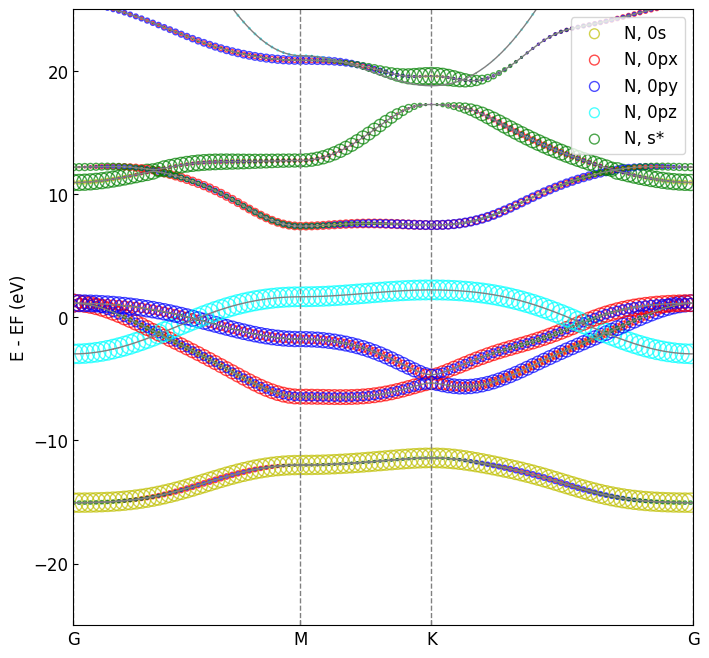

In [4]:
plt.figure(figsize=(8,8),dpi=100)
alpha=0.7
interp=2
for i in range(eigks.shape[1]):
    #plt.plot(xlist, eig[:,i]*13.605662285137 * 2-np.min(eigks),'r-',lw=1)
    plt.plot(xlist, eigks[:,i]+5,'-',c='gray',lw=1)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,0,i],facecolors='none',edgecolors='y', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,3,i],facecolors='none',edgecolors='r', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,1,i],facecolors='none',edgecolors='b', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,2,i],facecolors='none',edgecolors='cyan', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,4,i],facecolors='none',edgecolors='g', lw=1,alpha=alpha)

shift=1000
for i in range(1):
    #plt.plot(xlist, eig[:,i]*13.605662285137 * 2-np.min(eigks),'r-',lw=1)
    plt.plot(xlist, eigks[:,i]+5,'-',c='gray',lw=1)
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='y',    lw=1,alpha=alpha,label='N, 0s')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='r',    lw=1,alpha=alpha,label='N, 0px')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='b',    lw=1,alpha=alpha,label='N, 0py')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='cyan', lw=1,alpha=alpha,label='N, 0pz')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='g', lw=1,alpha=alpha,label='N, s*')

plt.legend(loc=1,fontsize=12)

    
for ii in high_sym_kpoints:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
plt.ylim(-25,25)
plt.xlim(xlist.min(),xlist.max())
plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(high_sym_kpoints, labels, fontsize=12)
#plt.savefig('nn_proj_N_band.pdf')
plt.show()

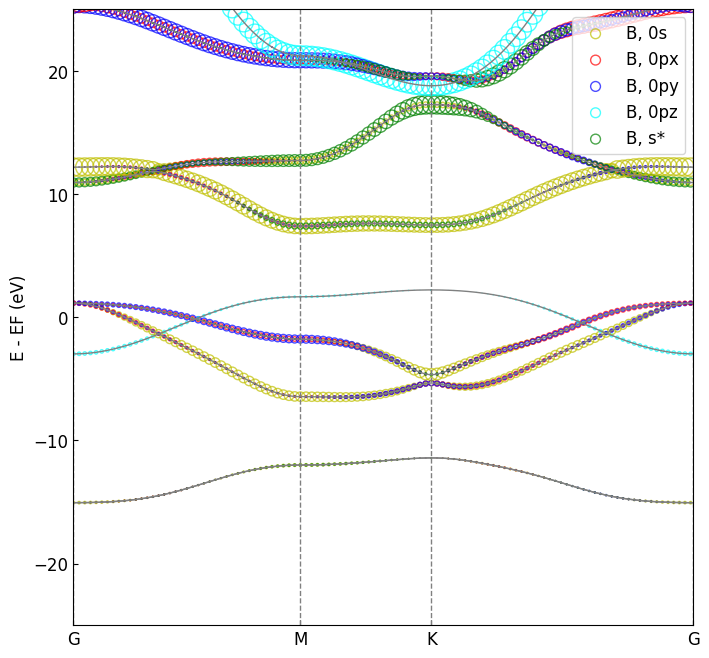

In [5]:
plt.figure(figsize=(8,8),dpi=100)
alpha=0.7
interp=2
for i in range(eigks.shape[1]):
    #plt.plot(xlist, eig[:,i]*13.605662285137 * 2-np.min(eigks),'r-',lw=1)
    plt.plot(xlist, eigks[:,i]+5,'-',c='gray',lw=1)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,0+5,i],facecolors='none',edgecolors='y', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,3+5,i],facecolors='none',edgecolors='r', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,1+5,i],facecolors='none',edgecolors='b', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,2+5,i],facecolors='none',edgecolors='cyan', lw=1,alpha=alpha)
    plt.scatter(xlist[::interp], eigks[::interp,i]+5,200*wei[::interp,4+5,i],facecolors='none',edgecolors='g', lw=1,alpha=alpha)

shift=1000
for i in range(1):
    #plt.plot(xlist, eig[:,i]*13.605662285137 * 2-np.min(eigks),'r-',lw=1)
    plt.plot(xlist, eigks[:,i]+5,'-',c='gray',lw=1)
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='y',    lw=1,alpha=alpha,label='B, 0s')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='r',    lw=1,alpha=alpha,label='B, 0px')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='b',    lw=1,alpha=alpha,label='B, 0py')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='cyan', lw=1,alpha=alpha,label='B, 0pz')
    plt.scatter(xlist[::interp], eigks[::interp,i]+shift,50 ,facecolors='none',edgecolors='g',    lw=1,alpha=alpha,label='B, s*')

plt.legend(loc=1,fontsize=12)

    
for ii in high_sym_kpoints:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
plt.ylim(-25,25)
plt.xlim(xlist.min(),xlist.max())
plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(high_sym_kpoints, labels, fontsize=12)
#plt.savefig('nn_proj_B_band.pdf')
plt.show()

In [6]:
hamil_blocks

[tensor([[-0.6143,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.1499, -0.0000, -0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.1499, -0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000, -0.1499,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.5857]], grad_fn=<CopySlices>),
 tensor([[0.0627, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7617, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.7617, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7617, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.9002]], grad_fn=<CopySlices>),
 tensor([[-0.0084, -0.0000, -0.0000,  0.0424, -0.0436],
         [ 0.0000, -0.0158,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0158,  0.0000,  0.0000],
         [-0.0424,  0.0000,  0.0000,  0.0357, -0.0260],
         [-0.0436, -0.0000, -0.0000,  0.0260, -0.0024]], grad_fn=<CopySlices>),
 tensor([[ 0.0253,  0.0050, -0.0000,  0.0086,  0.0376],
         [-0.0589, -0.0096,  0.0000, -0.1113,  0.0031],
 